In [1]:
from google.colab import drive

drive.mount('/proj')

Mounted at /proj


In [2]:
!pip install -q -U umap-learn[plot] hdbscan tensorflow-addons #opencv-python==4.5.1.48

     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 6.4MB 10.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 686kB 26.5MB/s 
     |████████████████████████████████| 1.2MB 35.8MB/s 
     |████████████████████████████████| 15.8MB 152kB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 706kB 43.9MB/s 
     |████████████████████████████████| 112kB 41.1MB/s 
ERROR: distributed 2021.5.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.5.0 has requirement dask==2021.05.0, but you'll have dask 2.12.0 which is incompatible.


In [3]:
#Imports

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import io
import numpy as np

###UMAP seems to take a while to import due to a pynndescent dependency (which uses numba).
import umap
import umap.plot
import hdbscan
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import shutil

from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier

In [4]:
CHECKPOINT_DIR="/proj/MyDrive/158780_Project_Dolphin_Computer_Vision/models/triplet_loss_dolphin/training/"
SEED = 100
VAL_PROP = 0.15
DIM=128
CHANNELS=3
data_dir = "/content/final_pigmentation_catalogue_2016"
test_dir = "/content/test"

In [5]:
shutil.rmtree(data_dir, ignore_errors=True)

In [10]:
!unzip /proj/MyDrive/158780_Project_Dolphin_Computer_Vision/images/final_pigmentation_catalogue_2016.zip -d /content

Archive:  /proj/MyDrive/158780_Project_Dolphin_Computer_Vision/images/final_pigmentation_catalogue_2016.zip
   creating: /content/final_pigmentation_catalogue_2016/0002/
  inflating: /content/final_pigmentation_catalogue_2016/0002/HG_090329_0030_NB.png  
  inflating: /content/final_pigmentation_catalogue_2016/0002/HG_100119_004_SD_N1.png  
  inflating: /content/final_pigmentation_catalogue_2016/0002/HG_100429_003_SD.png  
  inflating: /content/final_pigmentation_catalogue_2016/0002/HG_100429_004_SD.png  
  inflating: /content/final_pigmentation_catalogue_2016/0002/HG_100429_008_SD_N1.png  
  inflating: /content/final_pigmentation_catalogue_2016/0002/HG_100429_011_SD.png  
   creating: /content/final_pigmentation_catalogue_2016/0004/
  inflating: /content/final_pigmentation_catalogue_2016/0004/HG_120524_135_E1_HT.png  
  inflating: /content/final_pigmentation_catalogue_2016/0004/HG_120524_153_E1_LH_N3.png  
  inflating: /content/final_pigmentation_catalogue_2016/0004/HG_130719_107_E2_CL

We will build the stratified testing set with 10% of the dataset per class. As far as I'm aware, keras can't be used for this.

In [11]:
shutil.rmtree(test_dir, ignore_errors=True)
for dir in Path(data_dir).glob('*'):
  class_test_dir = f"/content/test/{dir.name}"
  Path(class_test_dir).mkdir(parents = True, exist_ok = True)
  images = list(dir.glob('*.png'))
  test_prop = round(len(images) * 0.1)
  for i in range(test_prop):
    test_file = random.choice(images)
    while os.path.exists(f"{class_test_dir}/{test_file.name}"): test_file = random.choice(images)
    shutil.move(str(test_file), class_test_dir)

In [12]:
!ls /content/test/0004

HG_130719_268_E2_CL.png  HG_131115_2200_E4_CL_AII.png  HG_131115_425_E1_BL.png
HG_130719_281_E2_CL.png  HG_131115_2201_E4_CL_AII.png


We'll use transfer learning with a ResNet50 backbone with an L2 normaliser and online image augmentation. We load ResNet50, inialised with imagenet weights. Critically, the final dense layer has no activiation function - we don't want to perform any non-linear transformations prior to nornalisation.

We use a 2048 unit dense layer, using Leaky ReLu as its activation function. This is followed by batch normalisation for regularisation. Next, a 1024 unit dense layer with ,batch normalisation, a final 256 unit dense layer with no activation function, and L2 normalisation.

In [15]:
batch_size=128
from tensorflow.keras.applications.resnet import ResNet50
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(DIM,DIM,CHANNELS)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
    tf.keras.layers.experimental.preprocessing.RandomTranslation((-.15, .15), (-.15, .15), fill_mode='reflect',interpolation='bilinear'),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(DIM,DIM,CHANNELS)),
    base_model,
    tf.keras.layers.Dense(2048, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=None),  
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  
])

In [16]:
model.build(input_shape=(DIM,DIM,CHANNELS))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 2048)             

We load the dataset, visualise the classes, and apply both pre-fetching and caching for performance.

In [17]:
def build_data(batch_size):
  train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      labels="inferred",
      label_mode="int",
      class_names=None,
      color_mode="rgb",
      batch_size=batch_size,
      image_size=(DIM, DIM),
      shuffle=True,
      seed=SEED,
      validation_split=VAL_PROP,
      subset="training",
      interpolation="bilinear",
      follow_links=False,
  )

  val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      labels="inferred",
      label_mode="int",
      class_names=None,
      color_mode="rgb",
      batch_size=batch_size,
      image_size=(DIM, DIM),
      shuffle=True,
      seed=SEED,
      validation_split=VAL_PROP,
      subset="validation",
      follow_links=False,
  )

  full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      labels="inferred",
      label_mode="int",
      color_mode="rgb",
      # batch_size=batch_size,
      image_size=(DIM, DIM),
      shuffle=True,
      seed=SEED,
  )

  test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      labels="inferred",
      label_mode="int",
      color_mode="rgb",
      # batch_size=batch_size,
      image_size=(DIM, DIM),
      shuffle=True,
      seed=SEED,
  )
  return train_dataset, val_dataset, full_dataset, test_dataset

def prefetch_data(batch_size):
  train_dataset, val_dataset, full_dataset, test_dataset = build_data(batch_size)
  train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
  val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  full_dataset = full_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
  test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
  return train_dataset, val_dataset, full_dataset, test_dataset

train_dataset, val_dataset, full_dataset, test_dataset = build_data(68)

Found 3364 files belonging to 186 classes.
Using 2860 files for training.
Found 3364 files belonging to 186 classes.
Using 504 files for validation.
Found 3364 files belonging to 186 classes.
Found 382 files belonging to 186 classes.


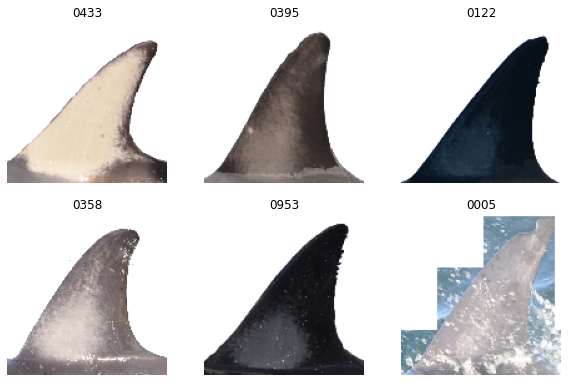

In [ ]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
train_dataset, val_dataset, full_dataset, test_dataset = prefetch_data(68)

Found 3364 files belonging to 186 classes.
Using 2860 files for training.
Found 3364 files belonging to 186 classes.
Using 504 files for validation.
Found 3364 files belonging to 186 classes.
Found 382 files belonging to 186 classes.


We first perform online learning with triplet hard loss and a soft margin of 2.

In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adamax(0.001),
  loss=tfa.losses.TripletHardLoss(2, soft = True)
)

In [28]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [29]:
history = model.fit(
  train_dataset,
  validation_data = val_dataset,
  epochs = 50,
  callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),            
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights = True, patience = 30),
    tf.keras.callbacks.ModelCheckpoint(f"{CHECKPOINT_DIR}/training_semi_resnet_aug", monitor= 'val_loss', save_best_only = True, mode = "min", save_weights_only = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, mode="min", min_delta=0.0001, min_lr = 0)
  ]
)

Epoch 1/50
43/43 [==============================] - 3s 63ms/step - loss: 0.4874 - val_loss: 0.5372
Epoch 2/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4867 - val_loss: 0.5367
Epoch 3/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4890 - val_loss: 0.5369
Epoch 4/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4862 - val_loss: 0.5363
Epoch 5/50
43/43 [==============================] - 3s 62ms/step - loss: 0.4877 - val_loss: 0.5358
Epoch 6/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4883 - val_loss: 0.5359
Epoch 7/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4863 - val_loss: 0.5363
Epoch 8/50
43/43 [==============================] - 3s 61ms/step - loss: 0.4854 - val_loss: 0.5366
Epoch 9/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4878 - val_loss: 0.5362
Epoch 10/50
43/43 [==============================] - 3s 60ms/step - loss: 0.4840 - val_loss: 0.5370
Epoch 11/

We visualise the training results.

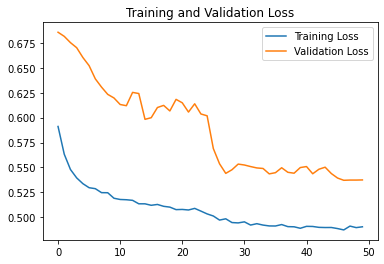

In [25]:
def plot_loss(history):
  epochs = len(history.history['loss'])
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_loss(history)

Not bad, but we consistently reach a loss plateau.

In [34]:
def fit_model(epochs, batch_size):
  train_dataset, val_dataset, full_dataset, test_dataset = prefetch_data(batch_size)
  model.load_weights(f"{CHECKPOINT_DIR}/training_semi_resnet_aug")
  history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs,
    callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),            
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights = True, patience = 30),
      tf.keras.callbacks.ModelCheckpoint(f"{CHECKPOINT_DIR}/training_semi_resnet_aug", monitor= 'val_loss', save_best_only = True, mode = "min", save_weights_only = True),
      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, mode="min", min_delta=0.0001, min_lr = 0)    
    ]
  )
  return history


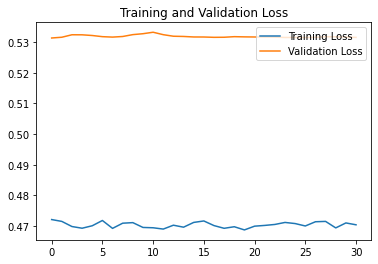

In [36]:
history = fit_model(50, 64)
plot_loss(history)

It seems we've hit a loss plateau. We'll try decreasing the learning rate.


In [39]:
def compile_model(lr, loss):
  model.compile(
    optimizer=tf.keras.optimizers.Adamax(lr),
    loss=loss
  )

Found 3364 files belonging to 186 classes.
Using 2860 files for training.
Found 3364 files belonging to 186 classes.
Using 504 files for validation.
Found 3364 files belonging to 186 classes.
Found 382 files belonging to 186 classes.
Epoch 1/50
23/23 [==============================] - 92s 694ms/step - loss: 1.6820 - val_loss: 1.8486
Epoch 2/50
23/23 [==============================] - 2s 96ms/step - loss: 1.7022 - val_loss: 1.8486
Epoch 3/50
23/23 [==============================] - 2s 96ms/step - loss: 1.6726 - val_loss: 1.8487
Epoch 4/50
23/23 [==============================] - 2s 96ms/step - loss: 1.6996 - val_loss: 1.8489
Epoch 5/50
23/23 [==============================] - 2s 96ms/step - loss: 1.7052 - val_loss: 1.8487
Epoch 6/50
23/23 [==============================] - 2s 96ms/step - loss: 1.6776 - val_loss: 1.8487
Epoch 7/50
23/23 [==============================] - 2s 98ms/step - loss: 1.6726 - val_loss: 1.8488
Epoch 8/50
23/23 [==============================] - 2s 97ms/step - loss

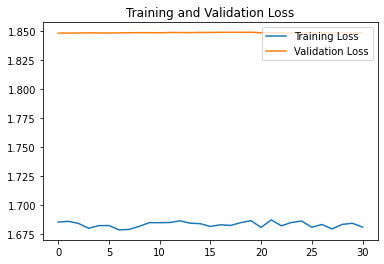

In [43]:
compile_model(1e-07, tfa.losses.TripletHardLoss(2, soft = False))
history = fit_model(50, 128)
plot_loss(history)

Again, we've reached a plateau.

We'll switch back to semi-hard loss

 So, we will generate the embeddings, visualise them, and use a KNN classifier.

In [45]:
train_embeddings = model.predict(full_dataset)
test_embeddings = model.predict(test_dataset)
train_embeddings.shape

(3364, 256)

We retrieve the class labels.

In [46]:
y_train = np.concatenate([y for x, y in full_dataset], axis=0)
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
y_train[0:100]

array([172, 115,   9,   3,  14,  60, 119,  92,  34, 104,  19, 172,  36,
       101, 172,  94, 182, 172,  67, 140,  79,  82, 140,  36, 181,  79,
       144, 134, 152, 122,  46,  64,  60,  60,  96, 153,  32,  13,  42,
        72, 138, 160,  60, 152,  87, 127, 181, 127,  82,  55, 124, 140,
       125,  79,  43,  92, 107,  82, 108, 167, 101, 153, 104,  53,   5,
       153, 156,  19,  37, 131, 124, 119, 119,   0, 166, 145,  84,   1,
        92, 104, 121,  13,  79, 182,  84,  43,  73,  66,  57, 154,  84,
       173,  99,   3,  24, 181,  66, 182,  74, 119], dtype=int32)

Next, we plot the results.

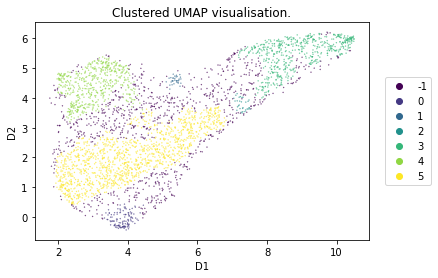

In [47]:
mapper=umap.UMAP( n_neighbors = 100, min_dist= 0.1).fit(train_embeddings, y_train)
cluster = hdbscan.HDBSCAN(
    algorithm ='best', 
    approx_min_span_tree = True,
    gen_min_span_tree = False, 
    leaf_size = 40, 
    metric='euclidean', 
    min_cluster_size = 25,
    min_samples = 25, 
    p = None
).fit(mapper.embedding_)

plt.title("Clustered UMAP visualisation.")
scatter = plt.scatter(
    mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1],
    c = cluster.labels_,
    s = 0.1, 
)

plt.legend(
  handles = scatter.legend_elements()[0], 
  labels = pd.Series(cluster.labels_.tolist()).astype("string").sort_values().unique(),
  loc="right",
  bbox_to_anchor=(1.2, 0.5)
)
plt.xlabel("D1")
plt.ylabel("D2")
plt.show();

Not so good. The clusters are not well formed.

In [48]:
knn=KNeighborsClassifier(100)
knn.fit(mapper.embedding_, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [49]:
knn.score(mapper.transform(test_embeddings), y_test)

0.013089005235602094

The KNN classifier has not done a good job.

In [50]:
%%shell
jupyter nbconvert --to html /content/4_3_triplet_loss_dolphin_resnet_aug.ipynb

[NbConvertApp] WARNING | pattern u'/content/4_3_triplet_loss_dolphin_resnet_aug.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename

CalledProcessError: ignored